In [2]:
import numpy as np
import pandas as pd

import dowhy
from dowhy import CausalModel
import dowhy.datasets

c:\Users\pei4b\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = dowhy.datasets.linear_dataset(beta=10,  # beta 表示真實的因果效應
                                     num_common_causes=5,  # 混雜因子，用 W 表示，作用於干預變量和結果變量
                                     num_instruments=2,  # 工具變量，用 Z 表示，作用於干預變量（間接影響結果）
                                     num_effect_modifiers=1,  # 效果修改變量，用 X 表示，作用於結果變量
                                     num_samples=10000,  # 樣本數
                                     treatment_is_binary=True,  # 干預為二元變量，用 v 表示
                                     num_discrete_common_causes=1)
df = data["df"]  # DoWhy 使用 pandas 的 dataframe 來載入數據
print(df.head())
print(data["dot_graph"])  # 還可以輸出 gml_graph，內容一致只是表達形式不同

         X0   Z0        Z1        W0        W1        W2        W3 W4     v0  \
0 -0.964474  0.0  0.412273 -0.000617 -0.055771  0.821406  0.479162  1   True   
1 -1.191231  1.0  0.669518 -1.119455 -0.396382 -1.979263  0.394423  1   True   
2 -0.991796  0.0  0.749499 -1.641842  0.651514  0.108286 -0.329524  3  False   
3 -1.832361  0.0  0.531467 -2.732248 -1.636807  0.791494 -0.867975  3  False   
4  0.232626  0.0  0.797063 -0.447581 -0.873822  0.889405  0.162903  1   True   

           y  
0  16.288167  
1  -0.697554  
2  14.840006  
3  13.707854  
4  19.768421  
digraph {v0->y;W0-> v0; W1-> v0; W2-> v0; W3-> v0; W4-> v0;Z0-> v0; Z1-> v0;W0-> y; W1-> y; W2-> y; W3-> y; W4-> y;X0-> y;}


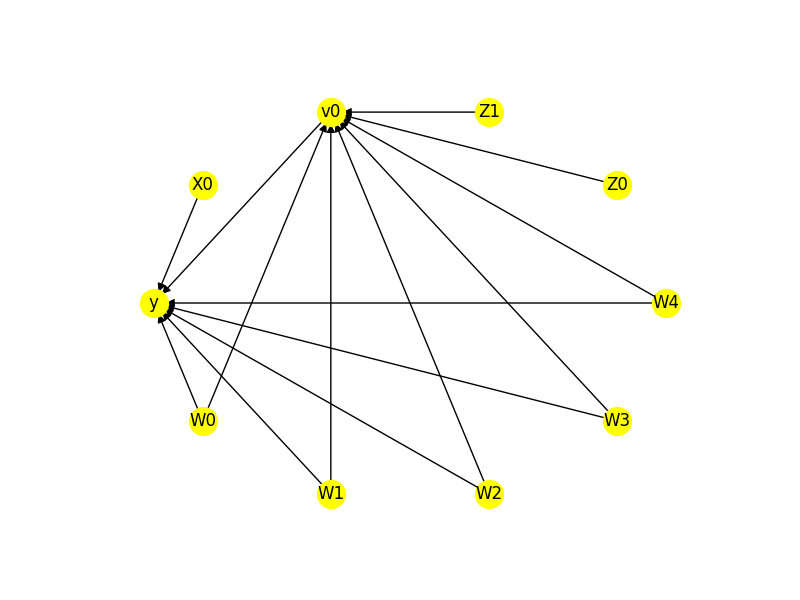

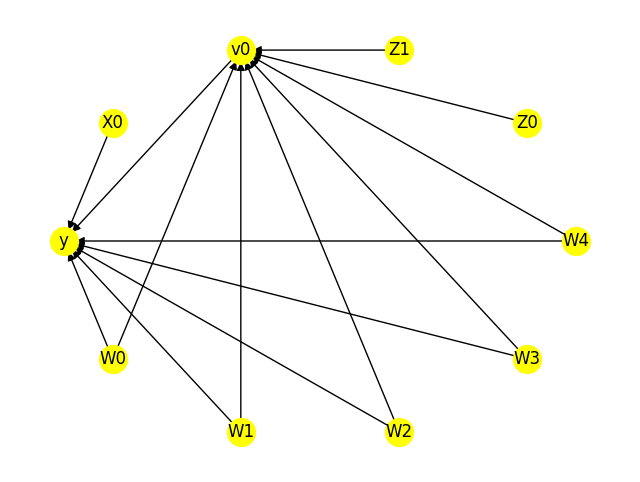

In [4]:
# With graph
model = CausalModel(
    data=df,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"]
)
# INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
model.view_model()
from IPython.display import Image, display

display(Image(filename="causal_model.png"))

In [5]:
# Without graph
model = CausalModel(
    data=df,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    instruments=data["instrument_names"],
    common_causes=data["common_causes_names"],
    effect_modifiers=data["effect_modifier_names"])

In [6]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W3,W0,W2,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W2,W4,U) = P(y|v0,W1,W3,W0,W2,W4)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [7]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W3,W0,W2,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W2,W4,U) = P(y|v0,W1,W3,W0,W2,W4)

## Realized estimand
b: y~v0+W1+W3+W0+W2+W4
Target units: ate

## Estimate
Mean value: 6.707493422246611

Causal Estimate is 6.707493422246611


In [8]:
res_random = model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:6.707493422246611
New effect:6.7074934222466105
p value:2.0



In [9]:
res_placebo = model.refute_estimate(identified_estimand, estimate,
                                    method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:6.707493422246611
New effect:-0.0003635667164800465
p value:0.94



In [10]:
res_subset = model.refute_estimate(identified_estimand, estimate,
                                   method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)